In [5]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.models import load_model


from preprocessing.image import extract_features, extract_feature_from_image
from preprocessing.text import create_tokenizer
from NIC import greedy_inference_model, image_dense_lstm, text_emb_lstm
from evaluate import decoder, beam_search

In [11]:
# use training token set to create vocabulary
train_dir = './datasets/Flickr8k_text/Flickr_8k.trainImages.txt'
token_dir = './datasets/Flickr8k_text/Flickr8k.token.txt'
# the current best trained model
model_dir = './model-params/current_best.h5'

In [12]:
# load vocabulary
tokenizer = create_tokenizer(train_dir, token_dir, start_end = True, use_all=True)

# set relevent parameters
vocab_size  = tokenizer.num_words or (len(tokenizer.word_index)+1)
max_len = 24 # use 24 as maximum sentence's length when training the model

## Greedy inference

In [13]:
NIC_inference = greedy_inference_model(vocab_size, max_len)
NIC_inference.load_weights(model_dir, by_name = True, skip_mismatch=True)

In [14]:
def generate_caption_from_file(file_dir):
    # Encoder
    img_feature = extract_feature_from_image(file_dir)
    # Decoder
    caption = decoder(NIC_inference, tokenizer, img_feature, True)
    
    return caption

def generate_caption_from_directory(file_directory):
    # Encoder
    img_features_dict = extract_features(file_directory)
    # Decoder
    captions = decoder(NIC_inference, tokenizer, img_features_dict['features'], True)
    
    return img_features_dict['ids'], captions

1/1 [==============================] - 0s 60ms/step


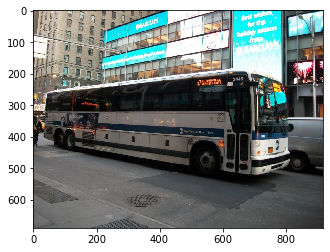

['a man and a woman are walking past a bus']


In [21]:
image_file_dir = './put-your-image-here/test5.jpg'

# display image
img = mpimg.imread(image_file_dir)
plt.imshow(img)

#generate caption
caption = generate_caption_from_file(image_file_dir)
plt.show()

print(caption)

6/6 [==============================] - 0s 49ms/step


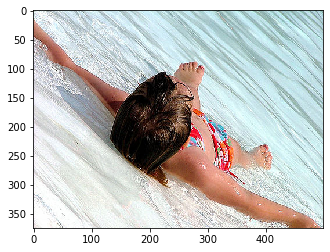

a girl in a bikini is jumping into a pool


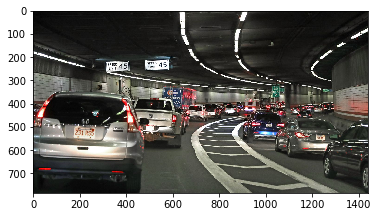

a man in a red shirt and a black and white car is walking down a street


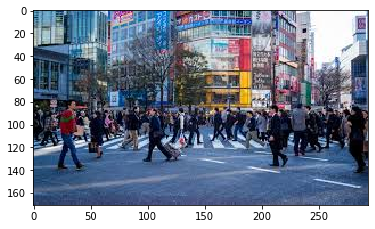

a group of people are walking down a street with a red and white and white and white and white and white


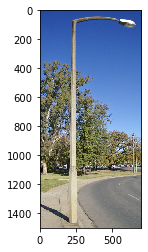

a man walks down a sidewalk


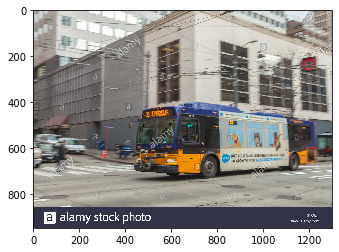

a man and a woman are sitting on a car


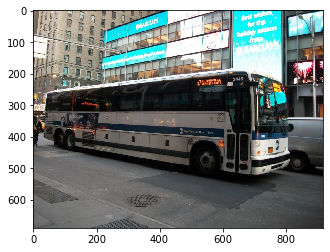

a man and a woman are walking past a bus


In [22]:
image_dir = './put-your-image-here'

img_names, captions = generate_caption_from_directory(image_dir)

for img_file in os.listdir(image_dir):
    img = mpimg.imread(image_dir + '/' + img_file)
    plt.imshow(img)
    
    img_name = os.path.splitext(img_file)[0]
    idx = img_names.index(img_name)
    
    plt.show()
    print(captions[idx])

## Beam search inference

In [23]:
# prepare inference model
NIC_text_emb_lstm = text_emb_lstm(vocab_size)
NIC_text_emb_lstm.load_weights(model_dir, by_name = True, skip_mismatch=True)
NIC_image_dense_lstm = image_dense_lstm()
NIC_image_dense_lstm.load_weights(model_dir, by_name = True, skip_mismatch=True)

In [24]:
def generate_caption_from_file(file_dir, beam_width = 5, alpha = 0.7):
    # Encoder
    img_feature = extract_feature_from_image(file_dir)
    # Decoder
    a0, c0 = NIC_image_dense_lstm.predict([img_feature, np.zeros([1, 512]), np.zeros([1, 512])])
    
    res = beam_search(NIC_text_emb_lstm, a0, c0, tokenizer, beam_width, max_len, alpha)
    best_idx = np.argmax(res['scores'])
    caption = tokenizer.sequences_to_texts([res['routes'][best_idx]])[0]
    
    return caption

def generate_caption_from_directory(file_directory, beam_width = 5, alpha = 0.7):
    # Encoder
    img_features_dict = extract_features(file_directory)
    # Decoder
    N = img_features_dict['features'].shape[0]
    a0, c0 = NIC_image_dense_lstm.predict([img_features_dict['features'], np.zeros([N, 512]), np.zeros([N, 512])])
    
    captions = []
    for i in range(N):
        res = beam_search(NIC_text_emb_lstm, a0[i, :].reshape(1,-1), c0[i, :].reshape(1,-1), tokenizer, beam_width, max_len, alpha)
        best_idx = np.argmax(res['scores'])
        captions.append(tokenizer.sequences_to_texts([res['routes'][best_idx]])[0])
    
    return img_features_dict['ids'], captions

In [30]:
from PIL import Image
img_file_dir = 'https://cdn.vox-cdn.com/thumbor/OLmEITTDROKSqsEcFu1lWs49pTg=/0x0:4080x2632/1220x813/filters:focal(1714x990:2366x1642):format(webp)/cdn.vox-cdn.com/uploads/chorus_image/image/65162674/shutterstock_1485499772.0.jpg'

img_file = Image.open(img_file_dir)
# display image
# img = mpimg.imread(image_file_dir)
# plt.imshow(img)

#generate caption
caption = generate_caption_from_file(img_file)
plt.show()

print(caption)

OSError: [Errno 22] Invalid argument: 'https://cdn.vox-cdn.com/thumbor/OLmEITTDROKSqsEcFu1lWs49pTg=/0x0:4080x2632/1220x813/filters:focal(1714x990:2366x1642):format(webp)/cdn.vox-cdn.com/uploads/chorus_image/image/65162674/shutterstock_1485499772.0.jpg'

6/6 [==============================] - 8s 1s/step


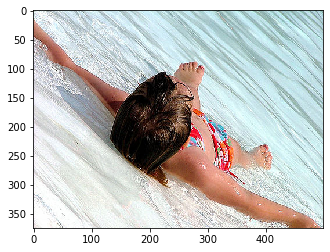

a girl in a pink bathing suit is playing in the water


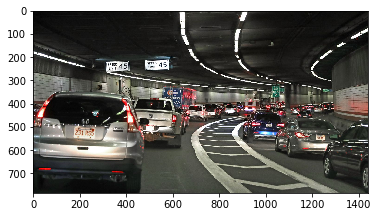

a group of people are standing in front of a city street


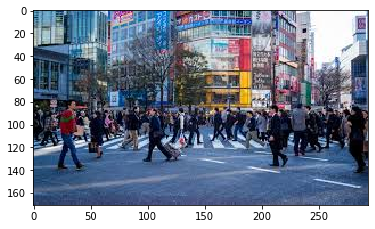

a group of people are walking down the street


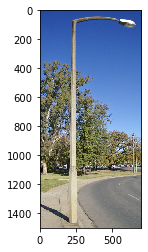

a man walks down the street in front of a building


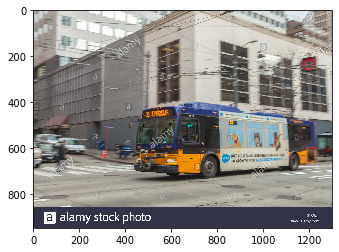

a group of people are standing in front of a truck


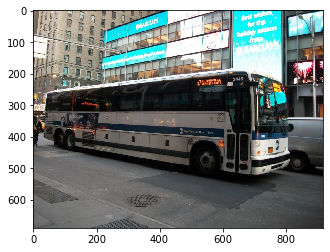

a man and a woman are standing in front of a bus


In [26]:
image_dir = './put-your-image-here'

img_names, captions = generate_caption_from_directory(image_dir, 10, 1)

for img_file in os.listdir(image_dir):
    img = mpimg.imread(image_dir + '/' + img_file)
    plt.imshow(img)
    
    img_name = os.path.splitext(img_file)[0]
    idx = img_names.index(img_name)
    
    plt.show()
    print(captions[idx])